# **Project Name : Email Spam Detection**

### Email spam detection is a crucial aspect of email security, aimed at identifying and filtering out unsolicited or unwanted emails. The objective of the email spam detection machine learning project is to develop a highly accurate model capable of efficiently distinguishing between spam and legitimate emails, thereby enhancing email security by reducing the risk of users being exposed to unsolicited or harmful messages.

In [274]:
# Importing the necessary dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score
import pickle

In [275]:
# loading the dataset to a pandas DataFrame
email_dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/spam.csv', encoding = 'latin-1')

In [276]:
# First 5 rows of the dataset
email_dataset.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [277]:
# Last 5 rows of the dataset
email_dataset.tail()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN
5571,ham,Rofl. Its true to its name,NaN,NaN,NaN


# **Data Preprocessing**

In [278]:
# Dataset informations
email_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [279]:
email_dataset.drop(columns =['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1, inplace = True)

In [280]:
email_dataset.sample(5)

,v1,v2
2320,ham,This pain couldn't have come at a worse time.
5006,ham,Oh k. . I will come tomorrow
3045,ham,So how's the weather over there?
2727,ham,Whatsup there. Dont u want to sleep
4750,spam,Your weekly Cool-Mob tones are ready to downlo...


In [281]:
# Renaming the columns
email_dataset.rename(columns = {'v1': 'target', 'v2': 'text'}, inplace = True)
email_dataset.sample(5)

,target,text
4816,ham,Me too. Mark is taking forever to pick up my p...
4723,spam,FREE GAME. Get Rayman Golf 4 FREE from the O2 ...
4546,ham,Hey mate. Spoke to the mag people. WeÛ÷re on....
1928,spam,Call from 08702490080 - tells u 2 call 0906635...
1547,ham,Bishan lar nearer... No need buy so early cos ...


In [282]:
# Label encoding for the target column
encoder = LabelEncoder()
email_dataset['target'] = encoder.fit_transform(email_dataset['target'])

In [283]:
email_dataset.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


Here '0' means not-spam (ham) and '1' means spam emails.

In [284]:
# Find shape of our dataset(Number of rows and number of columns)
print("Number of Rows", email_dataset.shape[0])
print("Number of Columns", email_dataset.shape[1])

Number of Rows 5572
Number of Columns 2


In [285]:
# Checking the number of missing values in each column
email_dataset.isnull().sum()

target    0
text      0
dtype: int64

There is no null values in the dataset

In [286]:
# Identifying duplicated values
email_dataset.duplicated().sum()

403

In [287]:
# Removing duplicated values
email_dataset = email_dataset.drop_duplicates(keep = 'first')

In [288]:
email_dataset.duplicated().sum()

0

In [289]:
email_dataset.shape

(5169, 2)

# **Feature Engineering**

**Exoploratoty Data Analysis (EDA)**

In [290]:
# Statistical measures of the data
email_dataset.describe()

,target
count,5169.000000
mean,0.126330
std,0.332253
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [291]:
# Distribution of Not-spam(ham) and spam emails
email_dataset['target'].value_counts()

target
0    4516
1     653
Name: count, dtype: int64

In [292]:
# Percentage of not-churning and churning customers
100*email_dataset['target'].value_counts()/len(email_dataset['target'])

target
0    87.366996
1    12.633004
Name: count, dtype: float64

* Data is imbalanced, ratio = 73:27

Text(0.5, 1.0, 'Email Class Distribution')

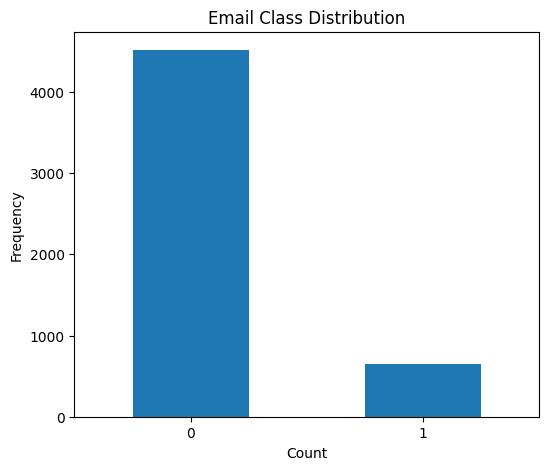

In [293]:
# Distribution of Not-spam(ham) and spam emails through bar chart
email_dataset['target'].value_counts().plot (kind= 'bar', figsize = (6, 5), rot = 0)
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.title ('Email Class Distribution')

As per the graph we can say the dataset is imbalanced

In [294]:
email_dataset['num_characters'] = email_dataset['text'].apply(len)

In [295]:
email_dataset.head()

,target,text,num_characters
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [296]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [297]:
# Number of words
email_dataset['num_words'] = email_dataset['text'].apply(lambda x : len(nltk.word_tokenize(x)))
email_dataset

,target,text,num_characters,num_words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15
...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,35
5568,0,Will Ì_ b going to esplanade fr home?,37,9
5569,0,"Pity, * was in mood for that. So...any other s...",57,15
5570,0,The guy did some bitching but I acted like i'd...,125,27


In [298]:
email_dataset['num_sentences'] = email_dataset['text'].apply(lambda x : len(nltk.sent_tokenize(x)))
email_dataset

,target,text,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1
...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,35,4
5568,0,Will Ì_ b going to esplanade fr home?,37,9,1
5569,0,"Pity, * was in mood for that. So...any other s...",57,15,2
5570,0,The guy did some bitching but I acted like i'd...,125,27,1


In [299]:
email_dataset[['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [300]:
email_dataset[email_dataset['target'] == 0][['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [301]:
email_dataset[email_dataset['target'] == 1][['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


<Axes: xlabel='num_characters', ylabel='Count'>

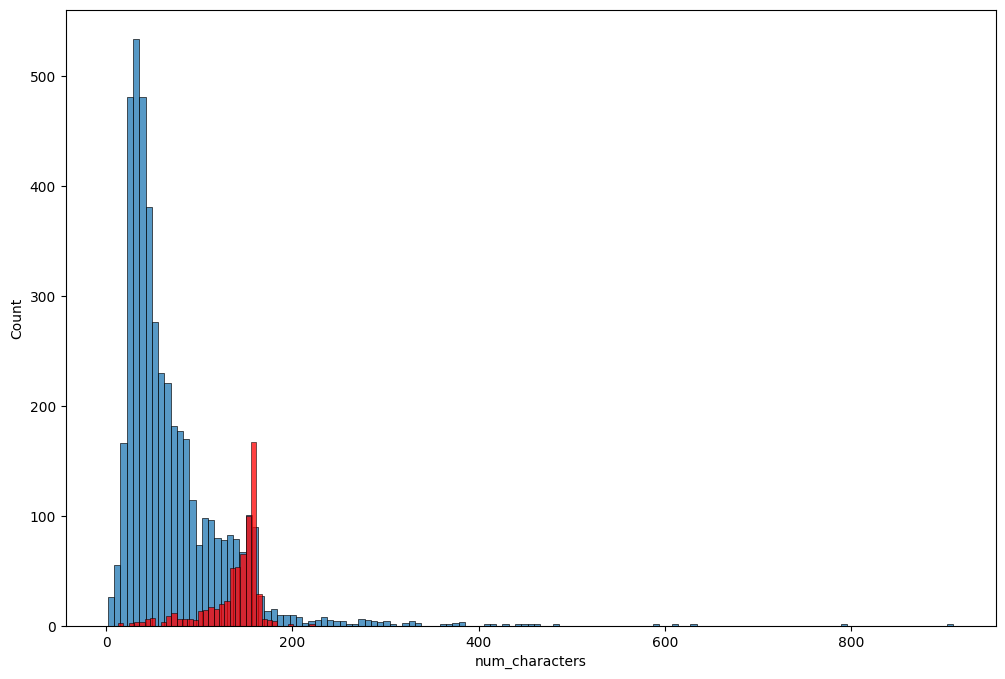

In [302]:
plt.figure(figsize = (12, 8))
sns.histplot(email_dataset[email_dataset['target'] == 0]['num_characters'])
sns.histplot(email_dataset[email_dataset['target'] == 1]['num_characters'], color = 'red')

<Axes: xlabel='num_words', ylabel='Count'>

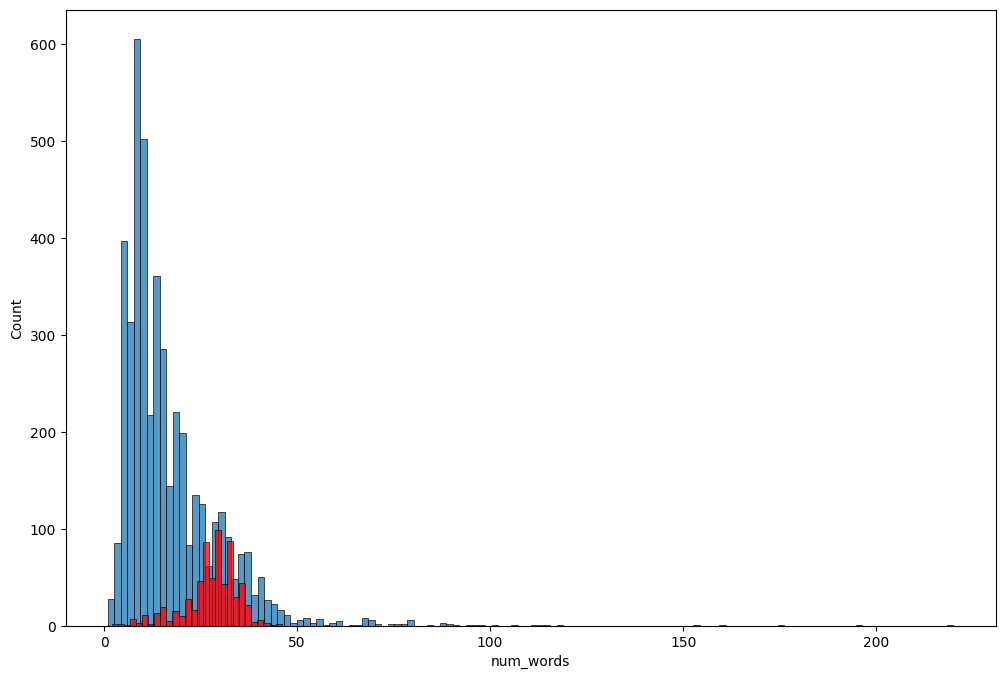

In [303]:
plt.figure(figsize = (12, 8))
sns.histplot(email_dataset[email_dataset['target'] == 0]['num_words'])
sns.histplot(email_dataset[email_dataset['target'] == 1]['num_words'], color = 'red')

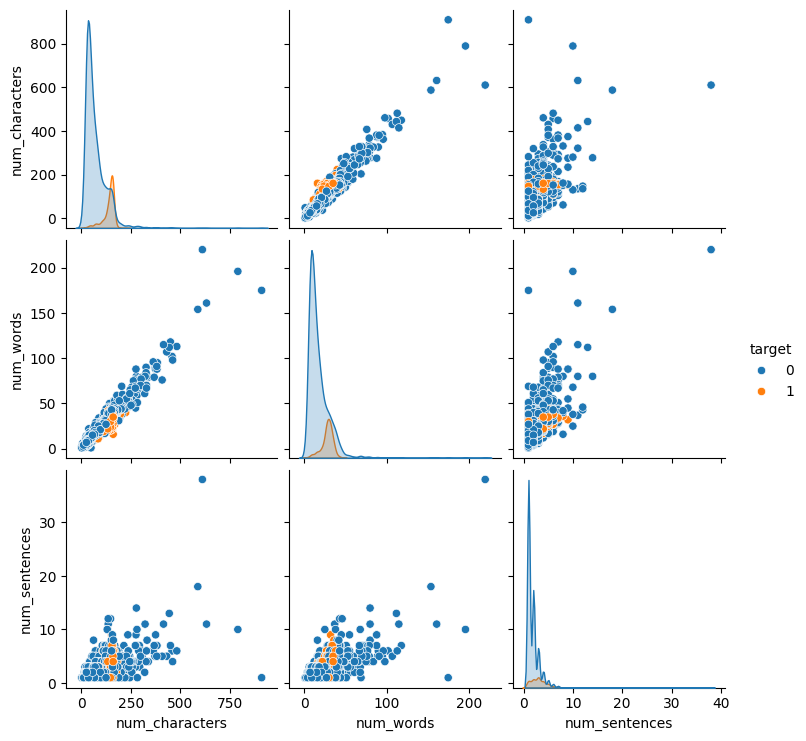

In [304]:
sns.pairplot(email_dataset, hue = 'target')

In [305]:
ps = PorterStemmer()
ps.stem('loving')

'love'

In [306]:
def transform_text(text):
  text = text.lower()
  text = nltk.word_tokenize(text)

  y = []
  for i in text:
      if i.isalnum():
        y.append(i)

  text = y[:]
  y.clear()

  for i in text:
      if i not in stopwords.words('english') and i not in string.punctuation:
          y.append(i)

  text = y[:]
  y.clear()

  for i in text:
      y.append(ps.stem(i))

  return " ".join(y)

In [307]:
email_dataset['text'][10]

"I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today."

In [308]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [309]:
transform_text("I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.")

'gon na home soon want talk stuff anymor tonight k cri enough today'

In [310]:
email_dataset['transformed_text'] = email_dataset['text'].apply(transform_text)

In [311]:
email_dataset.head()

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [312]:
wc = WordCloud(width = 500, height = 500, min_font_size=10, background_color= 'white')

In [313]:
spam_wc = wc.generate(email_dataset[email_dataset['target'] == 1]['transformed_text'].str.cat(sep =" "))

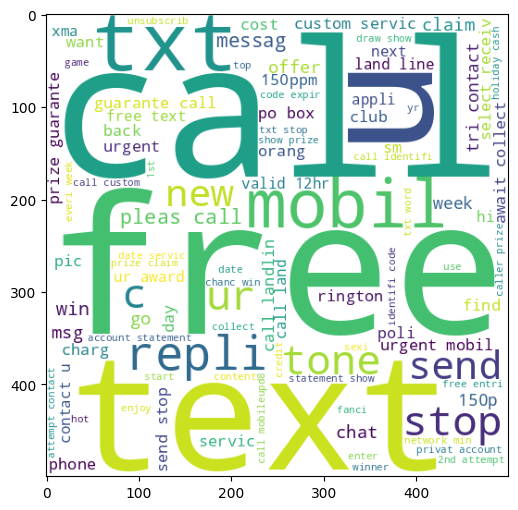

In [314]:
plt.figure(figsize = (15, 6))
plt.imshow(spam_wc)

In [315]:
ham_wc = wc.generate(email_dataset[email_dataset['target'] == 0]['transformed_text'].str.cat(sep =" "))

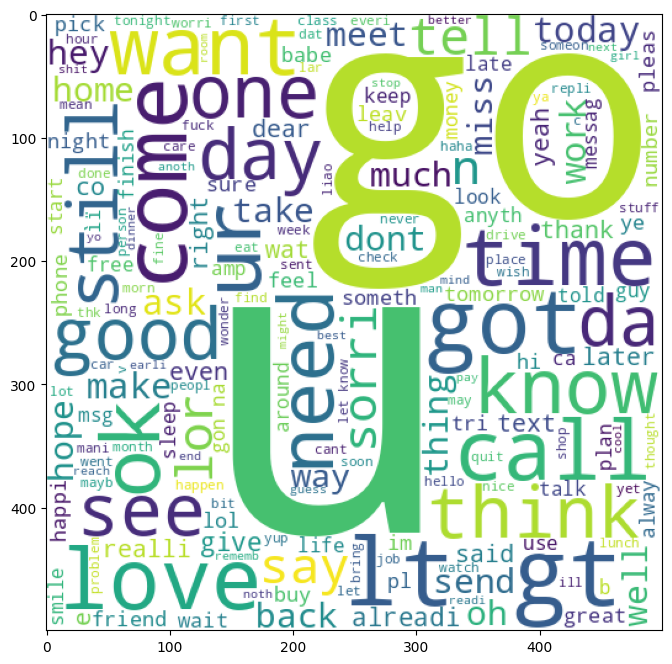

In [316]:
plt.figure(figsize = (15, 8))
plt.imshow(ham_wc)

In [317]:
spam_corpus = []
for msg in email_dataset[email_dataset['target'] ==1]['transformed_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)

In [318]:
len(spam_corpus)

9939

In [319]:
pd.DataFrame(Counter(spam_corpus).most_common(30))

,0,1
0,call,320
1,free,191
2,2,155
3,txt,141
4,text,122
5,u,119
6,ur,119
7,mobil,114
8,stop,104
9,repli,103


In [320]:
ham_corpus = []
for msg in email_dataset[email_dataset['target'] == 0]['transformed_text'].tolist():
    for word in msg.split():
        ham_corpus.append(word)

In [321]:
len(ham_corpus)

35404

In [322]:
pd.DataFrame(Counter(ham_corpus).most_common(30))

,0,1
0,u,883
1,go,404
2,get,349
3,gt,288
4,lt,287
5,2,284
6,come,275
7,got,236
8,know,236
9,like,234


# **Model Building**

In [323]:
cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features = 3000)

**Spliting the data into features & targets**

In [324]:
X = tfidf.fit_transform(email_dataset['transformed_text']).toarray()

In [325]:
X.shape

(5169, 3000)

In [326]:
y = email_dataset['target'].values

In [327]:
y

array([0, 0, 1, ..., 0, 0, 0])

In [328]:
# Split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [329]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [330]:
gnb.fit(X_train, y_train)
y_pred1 = gnb.predict(X_test)
print(accuracy_score(y_test, y_pred1))
print(confusion_matrix(y_test, y_pred1))
print(precision_score(y_test, y_pred1))

0.867504835589942
[[771 114]
 [ 23 126]]
0.525


In [331]:
mnb.fit(X_train, y_train)
y_pred2 = mnb.predict(X_test)
print(accuracy_score(y_test, y_pred2))
print(confusion_matrix(y_test, y_pred2))
print(precision_score(y_test, y_pred2))

0.9680851063829787
[[885   0]
 [ 33 116]]
1.0


In [332]:
bnb.fit(X_train, y_train)
y_pred3 = bnb.predict(X_test)
print(accuracy_score(y_test, y_pred3))
print(confusion_matrix(y_test, y_pred3))
print(precision_score(y_test, y_pred3))

0.9748549323017408
[[884   1]
 [ 25 124]]
0.992


**tfidf ---> MNB**

In [333]:
svc = SVC(kernel = 'sigmoid', gamma = 1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth = 5)
lrc = LogisticRegression(solver = 'liblinear', penalty = 'l1')
rfc = RandomForestClassifier(n_estimators = 50, random_state = 2)
abc = AdaBoostClassifier(n_estimators = 50, random_state = 2)
etc = ExtraTreesClassifier(n_estimators = 50, random_state = 2)
gbdt = GradientBoostingClassifier(n_estimators = 50, random_state = 2)
xgb = XGBClassifier(n_estimators = 50, random_state = 2)

In [334]:
# List of models
clfs = {
    'Support Vector Classifier' : svc,
    'KNeighbors Classifier' : knc,
    'Naive Bayes Classifier' : mnb,
    'Decision Tree Classifier' : dtc,
    'Logistic Regression' : lrc,
    'Random Forest Classifier' : rfc,
    'AdaBoost Classifier' : abc,
    'Extra Tree Classifier' : etc,
    'Gradient Boosting Classifier' : gbdt,
    'XGB Classifier' : xgb
}

In [335]:
def train_classifier (clf, X_train, y_train, X_test, y_test):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)

  return accuracy, precision

In [336]:
train_classifier(svc, X_train, y_train, X_test, y_test)

(0.9748549323017408, 0.9767441860465116)

In [337]:
accuracy_scores = []
precision_scores = []

for name, clf in clfs.items():

    current_accuracy,current_precision = train_classifier(clf, X_train, y_train, X_test, y_test)

    print("For ", name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)

    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

For  Support Vector Classifier
Accuracy -  0.9748549323017408
Precision -  0.9767441860465116
For  KNeighbors Classifier
Accuracy -  0.9090909090909091
Precision -  1.0
For  Naive Bayes Classifier
Accuracy -  0.9680851063829787
Precision -  1.0
For  Decision Tree Classifier
Accuracy -  0.9323017408123792
Precision -  0.8558558558558559
For  Logistic Regression
Accuracy -  0.9613152804642167
Precision -  0.9739130434782609
For  Random Forest Classifier
Accuracy -  0.9777562862669246
Precision -  1.0
For  AdaBoost Classifier
Accuracy -  0.9680851063829787
Precision -  0.967741935483871
For  Extra Tree Classifier
Accuracy -  0.9796905222437138
Precision -  0.9923076923076923
For  Gradient Boosting Classifier
Accuracy -  0.9555125725338491
Precision -  0.963963963963964
For  XGB Classifier
Accuracy -  0.971953578336557
Precision -  0.9761904761904762


In [338]:
performance_df = pd.DataFrame({'Algorithm' : clfs.keys(), 'Accuracy': accuracy_scores, 'Precision' : precision_scores}).sort_values('Precision', ascending = False)

In [339]:
performance_df

,Algorithm,Accuracy,Precision
1,KNeighbors Classifier,0.909091,1.000000
2,Naive Bayes Classifier,0.968085,1.000000
5,Random Forest Classifier,0.977756,1.000000
7,Extra Tree Classifier,0.979691,0.992308
0,Support Vector Classifier,0.974855,0.976744
9,XGB Classifier,0.971954,0.976190
4,Logistic Regression,0.961315,0.973913
6,AdaBoost Classifier,0.968085,0.967742
8,Gradient Boosting Classifier,0.955513,0.963964
3,Decision Tree Classifier,0.932302,0.855856
